In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.models import ResNet18_Weights
from sklearn.model_selection import train_test_split

In [2]:
class PokemonCardDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        card_id = str(row['id'])
        label = row['class_idx']

        img_path = os.path.join(self.image_folder, f'{card_id}.png')

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

## Hyperparameters
Standard values for everything, although I think that MAYBE a couple more epochs could have helped.

In [3]:
card_folder = 'pokemon_cards'
batch_size = 32
n_epochs = 10
lr = 0.001

## Setting CUDA
Training takes 35-40 minutes using my RTX3060. I haven't really tried training the model on the CPU.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## CSV

In [5]:
df = pd.read_csv('clean_pokemon_cards.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'clean_pokemon_cards.csv'

## Type Mapping

In [ ]:
unique_types = df['type'].unique().tolist()
print(f'{len(unique_types)} types: {unique_types}')

type_to_idx = {t: i for i, t in enumerate(unique_types)}
df['class_idx'] = df['type'].apply(lambda x: type_to_idx[x])

11 types: ['Darkness', 'Colorless', 'Grass', 'Water', 'Metal', 'Psychic', 'Lightning', 'Dragon', 'Fire', 'Fighting', 'Fairy']


## Train/Val/Test Split

In [ ]:
train_df, temp_df = train_test_split(df,
                                     test_size=0.30,
                                     stratify=df['class_idx'])

val_df, test_df = train_test_split(temp_df,
                                   test_size=0.5,
                                   stratify=temp_df['class_idx'])

print(f'Training set size: {len(train_df)}\n'
      f'Validation set size: {len(val_df)}\n'
      f'Test set size: {len(test_df)}')

Training set size:   9160
Validation set size: 1963
Test set size: 1964


## Augmentations and Preprocessing --> Transforms!

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomRotation(15),
                                       transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std),])

val_test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=mean, std=std),])

## Datasets and DataLoaders

In [ ]:
train_dataset = PokemonCardDataset(train_df,
                                   card_folder,
                                   transform=train_transforms)

val_dataset = PokemonCardDataset(val_df,
                                 card_folder,
                                 transform=val_test_transforms)

test_dataset = PokemonCardDataset(test_df,
                                  card_folder,
                                  transform=val_test_transforms)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

## ResNet18

In [ ]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(unique_types))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

## Training and Validation

In [ ]:
# Just saving values for the plots
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}/{n_epochs}\n'
          f'Train accuracy: {train_acc:.4f} | Train loss: {train_loss:.4f}\n'
          f'Val accuracy: {val_acc:.4f} | Val loss: {val_loss:.4f}')

Epoch 1/10
Train accuracy: 0.8162 | Train loss: 0.5992
Val accuracy: 0.8681 | Val loss: 0.4125
Epoch 2/10
Train accuracy: 0.8818 | Train loss: 0.3787
Val accuracy: 0.9002 | Val loss: 0.3053
Epoch 3/10
Train accuracy: 0.8865 | Train loss: 0.3555
Val accuracy: 0.9210 | Val loss: 0.2446
Epoch 4/10
Train accuracy: 0.9038 | Train loss: 0.3115
Val accuracy: 0.7972 | Val loss: 0.6349
Epoch 5/10
Train accuracy: 0.9086 | Train loss: 0.2907
Val accuracy: 0.9139 | Val loss: 0.2668
Epoch 6/10
Train accuracy: 0.9238 | Train loss: 0.2446
Val accuracy: 0.9302 | Val loss: 0.2113
Epoch 7/10
Train accuracy: 0.9266 | Train loss: 0.2324
Val accuracy: 0.9419 | Val loss: 0.1857
Epoch 8/10
Train accuracy: 0.9362 | Train loss: 0.1996
Val accuracy: 0.9435 | Val loss: 0.1995
Epoch 9/10
Train accuracy: 0.9388 | Train loss: 0.1880
Val accuracy: 0.9542 | Val loss: 0.1238
Epoch 10/10
Train accuracy: 0.9484 | Train loss: 0.1630
Val accuracy: 0.9485 | Val loss: 0.1414


## Model Evaluation

In [ ]:
pred_values = []
label_values = []

In [ ]:
model.eval()
test_running_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

        pred_values.extend(preds.cpu().numpy())
        label_values.extend(labels.cpu().numpy())

test_loss = test_running_loss / test_total
test_acc = test_correct / test_total
print(f'Final test accuracy: {test_acc:.4f}\n'
      f'Final test loss: {test_loss:.4f}')

Final test accuracy: 0.9582
Final test loss: 0.1286


### Saving the Model Weights

In [ ]:
model_save_path = 'pokemon_card_classifier.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Training completed!') #37 minutes

Training completed!


## Plots

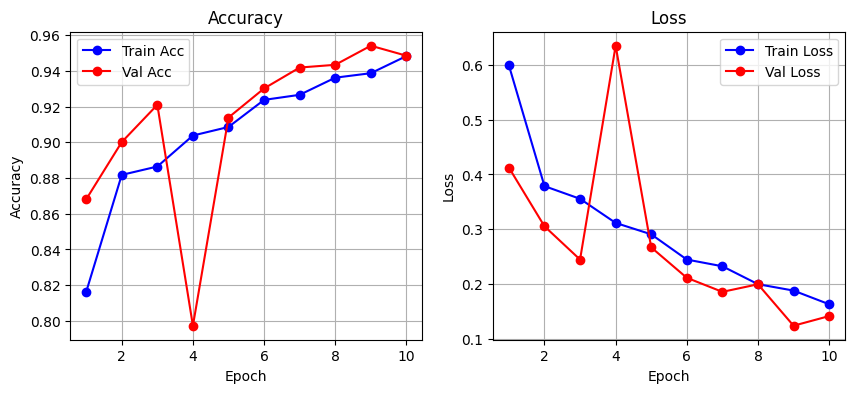

In [ ]:
epochs = range(1, n_epochs + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# acc
ax1.plot(epochs, train_accuracies, 'b-o', label='Train Acc')
ax1.plot(epochs, val_accuracies,   'r-o', label='Val Acc')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()

# loss
ax2.plot(epochs, train_losses, 'b-o', label='Train Loss')
ax2.plot(epochs, val_losses,   'r-o', label='Val Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.legend()

plt.show()

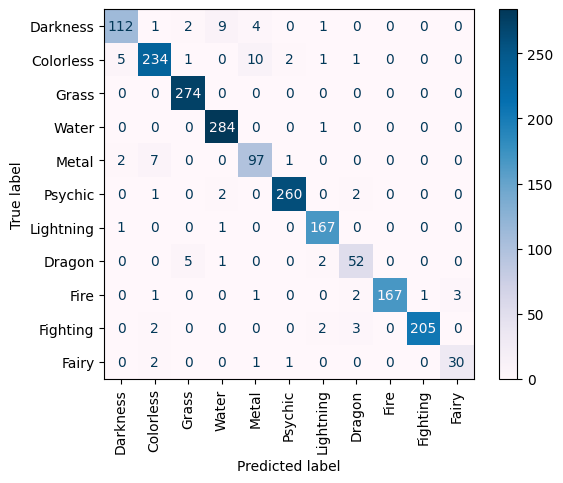

In [ ]:
cm = confusion_matrix(label_values, pred_values)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Darkness', 'Colorless', 'Grass', 'Water',
                                              'Metal', 'Psychic', 'Lightning', 'Dragon',
                                              'Fire', 'Fighting', 'Fairy'])


disp.plot(cmap=plt.cm.PuBu)
plt.xticks(rotation=90)
plt.show()